In [1]:
import os
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense

class ActorCriticNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=1024, fc2_dims=512,
                 name='actor_critic'):
        super(ActorCriticNetwork, self).__init__()
        self.n_actions = n_actions
        self.model_name = name
        
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        
        self.v = Dense(1, activation=None)
        self.pi = Dense(n_actions, activation='softmax')


    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)

        v = self.v(value)
        pi = self.pi(value)

        return v, pi

In [10]:
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

class Agent:
    def __init__(self, alpha=0.0003, gamma=0.99, n_actions=4):
        self.gamma = gamma # discount factor
        self.n_actions = n_actions
        self.action = None
        self.action_space = [i for i in range(n_actions)]
        self.actor_critic = ActorCriticNetwork(n_actions=n_actions)
        self.actor_critic.compile(optimizer=Adam(learning_rate=alpha))

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])
        _, probs = self.actor_critic(state)
        action_probabilities = tfp.distributions.Categorical(probs=probs)
        action = action_probabilities.sample()
        action_value = action.numpy()[0]
        action_clipped = min(max(action_value, 0), self.n_actions - 1)
        self.action = action_clipped
        return action_clipped

     

    def learn(self, state, reward, state_):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)

        with tf.GradientTape() as tape:
            state_value, probs = self.actor_critic(state)
            state_value_, _ = self.actor_critic(state_)
            state_value = tf.squeeze(state_value)
            state_value_ = tf.squeeze(state_value_)

            action_probs = tfp.distributions.Categorical(probs=probs)
            log_prob = action_probs.log_prob(self.action)

            delta = reward + self.gamma*state_value_ - state_value
            actor_loss = -log_prob*delta
            critic_loss = delta**2

            total_loss = actor_loss + critic_loss

        gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)
        
        self.actor_critic.optimizer.apply_gradients(zip(gradient, self.actor_critic.trainable_variables))       
        
        print("Actor Loss:", actor_loss.numpy())
        print("Critic Loss:", critic_loss.numpy())
        print("Gradients:", [grad.numpy() for grad in gradient])

In [3]:
import energyplus.ooep as ooep
import energyplus.ooep.ems
import energyplus.ooep.addons.state

from energyplus.dataset.basic import dataset as epds

env = energyplus.ooep.ems.Environment().__enter__()

sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build3/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./new1ch.idf',
    verbose=True,
)


In [8]:
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']
while True:

    score = 0
    sm_stepf()


    try:

        P_ch = [env.variable(dict(
                    variable_name='Chiller Electricity Rate',
                    variable_key=key)) for key in keys]
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value

        print(power)
        break

    except ooep.ems.NotReadyError: pass

0.0


In [13]:

import numpy as np
score_history = []
eps_history = []
powers = []
setpoints = []
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

agent = Agent(alpha=1e-8, gamma=0.9, n_actions=4)
episode_counter = 0

while episode_counter < 5:

    score = 0
    sm_stepf()


    

    P_ch = [env.variable(dict(
                variable_name='Chiller Electricity Rate',
                variable_key=key)) for key in keys]
    power = P_ch[0].value + P_ch[1].value + P_ch[2].value

    
    power_sum = 0

    # Add Chiller Electricity values to the observation space
    for chiller_electricity_rate in P_ch:
        power_sum += chiller_electricity_rate.value

    if power_sum != 0:

        episode_counter += 1

        for i in range(10000):

            obs = []
            P_ch = [env.variable(dict(
                variable_name='Chiller Electricity Rate',
                variable_key=key)) for key in keys]
            E_ch = [env.variable(dict(
                variable_name='Chiller Electricity', 
                variable_key=key)) for key in keys]
            T_outdoor = env.variable(dict(
                variable_name='Site Outdoor Air Drybulb Temperature',
                variable_key='ENVIRONMENT'))
            T_chws = [env.variable(dict(
                variable_name='Chiller Evaporator Outlet Temperature', 
                variable_key=key)) for key in keys]
            T_chwr = [env.variable(dict(
                variable_name='Chiller Evaporator Inlet Temperature', 
                variable_key=key)) for key in keys]
            T_chws_set = env.actuator(dict(
                component_type='System Node Setpoint',
                control_type = 'Temperature Setpoint', 
                actuator_key='CHW Loop Supply Side Outlet'))

            powers.append(power)

            for chiller_electricity_rate in P_ch:
                obs.append(chiller_electricity_rate.value)
                power_sum += chiller_electricity_rate.value
        
            reward = 1000000/(power_sum + 20000)

            score += reward

            # Add Site Outdoor Air Drybulb Temperature to the observation space
            obs.append(T_outdoor.value)

            # Add Chiller Evaporator Outlet Temperature values to the observation space
            for chiller_evaporator_outlet_temp in T_chws:
                obs.append(chiller_evaporator_outlet_temp.value)

            # Add Chiller Evaporator Inlet Temperature values to the observation space
            for chiller_evaporator_inlet_temp in T_chwr:
                obs.append(chiller_evaporator_inlet_temp.value)
        
            action = agent.choose_action(obs)
            sm_stepf()

            score += reward

            P_ch_ = [env.variable(dict(
                variable_name='Chiller Electricity Rate',
                variable_key=key)) for key in keys]
            E_ch_ = [env.variable(dict(
                variable_name='Chiller Electricity', 
                variable_key=key)) for key in keys]
            T_outdoor_ = env.variable(dict(
                variable_name='Site Outdoor Air Drybulb Temperature',
                variable_key='ENVIRONMENT'))
            T_chws_ = [env.variable(dict(
                variable_name='Chiller Evaporator Outlet Temperature', 
                variable_key=key)) for key in keys]
            T_chwr_ = [env.variable(dict(
                variable_name='Chiller Evaporator Inlet Temperature', 
                variable_key=key)) for key in keys]
            T_chws_set_ = env.actuator(dict(
                component_type='System Node Setpoint',
                control_type = 'Temperature Setpoint', 
                actuator_key='CHW Loop Supply Side Outlet'))
                    
            obs_ = []
            # Add Chiller Electricity values to the observation space
            for chiller_electricity_rate in P_ch_:
                obs_.append(chiller_electricity_rate.value)

            # Add Site Outdoor Air Drybulb Temperature to the observation space
            obs_.append(T_outdoor_.value)

            # Add Chiller Evaporator Outlet Temperature values to the observation space
            for chiller_evaporator_outlet_temp in T_chws_:
                obs_.append(chiller_evaporator_outlet_temp.value)

            # Add Chiller Evaporator Inlet Temperature values to the observation space
            for chiller_evaporator_inlet_temp in T_chwr_:
                obs_.append(chiller_evaporator_inlet_temp.value)

            agent.learn(obs, reward, obs_)

            setpoints.append(action + 6)

            print(rf"P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)
            
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        print('episode', episode_counter, 'score %.1f' % score, 'avg score %.1f' % avg_score)



P_ch=(66132.94791236249, 0.0, 0.0)) Reward=6.508141352457473 (T_outdoor=25.71666666666667) (T_chws_set=8) 
P_ch=(66132.94791236249, 0.0, 0.0)) Reward=4.549866922076931 (T_outdoor=25.71666666666667) (T_chws_set=9) 
P_ch=(67248.24712033379, 0.0, 29485.664674003165)) Reward=3.497486755112015 (T_outdoor=25.933333333333337) (T_chws_set=9) 
P_ch=(67248.24712033379, 0.0, 29485.664674003165)) Reward=2.6133302835553667 (T_outdoor=25.933333333333337) (T_chws_set=9) 


Actor Loss: [0.]
Critic Loss: 149054.62
Gradients: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan

P_ch=(66523.42404868882, 0.0, 28036.01853071323)) Reward=2.085995500007237 (T_outdoor=26.15) (T_chws_set=9) 
P_ch=(66523.42404868882, 0.0, 28036.01853071323)) Reward=1.742321573535459 (T_outdoor=26.15) (T_chws_set=9) 
P_ch=(65951.14537083317, 0.0, 26891.461175001947)) Reward=1.4958722048157138 (T_outdoor=26.366666666666667) (T_chws_set=9) 


Actor Loss: [nan]
Critic Loss: nan
Gradients: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan

P_ch=(65951.14537083317, 0.0, 26891.461175001947)) Reward=1.3134582386348648 (T_outdoor=26.366666666666667) (T_chws_set=9) 
P_ch=(65948.83923110239, 0.0, 26886.848895540392)) Reward=1.1706976469891457 (T_outdoor=26.583333333333336) (T_chws_set=9) 
P_ch=(65948.83923110239, 0.0, 26886.848895540392)) Reward=1.0559358735542883 (T_outdoor=26.583333333333336) (T_chws_set=9) 
P_ch=(65800.67177924034, 0.0, 26590.513991816297)) Reward=0.9616652403805047 (T_outdoor=26.8) (T_chws_set=9) 
P_ch=(65800.67177924034, 0.0, 26590.513991816297)) Reward=0.8831939913432704 (T_outdoor=26.8) (T_chws_set=9) 


Actor Loss: [nan]
Critic Loss: nan
Gradients: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan

P_ch=(65877.27004434448, 0.0, 26743.710522024543)) Reward=0.8165629901737187 (T_outdoor=27.0) (T_chws_set=9) 
P_ch=(65877.27004434448, 0.0, 26743.710522024543)) Reward=0.7591479724710883 (T_outdoor=27.0) (T_chws_set=9) 
P_ch=(66814.00596262889, 0.0, 28617.182358593425)) Reward=0.7092765868234643 (T_outdoor=27.200000000000003) (T_chws_set=9) 
P_ch=(66814.00596262889, 0.0, 28617.182358593425)) Reward=0.6643112779220386 (T_outdoor=27.200000000000003) (T_chws_set=9) 


Actor Loss: [nan]
Critic Loss: nan
Gradients: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan

P_ch=(66968.86749012314, 0.0, 28926.905413581895)) Reward=0.6247073232918642 (T_outdoor=27.4) (T_chws_set=9) 
P_ch=(66968.86749012314, 0.0, 28926.905413581895)) Reward=0.5893983586476318 (T_outdoor=27.4) (T_chws_set=9) 
P_ch=(66946.57413865879, 0.0, 28882.31871065316)) Reward=0.5578672492079921 (T_outdoor=27.6) (T_chws_set=9) 
P_ch=(66946.57413865879, 0.0, 28882.31871065316)) Reward=0.529557225400216 (T_outdoor=27.6) (T_chws_set=9) 


Actor Loss: [nan]
Critic Loss: nan
Gradients: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan

P_ch=(67085.23233511957, 0.0, 29159.63510357477)) Reward=0.5039817240138689 (T_outdoor=27.8) (T_chws_set=9) 
P_ch=(67085.23233511957, 0.0, 29159.63510357477)) Reward=0.48066667259811247 (T_outdoor=27.8) (T_chws_set=9) 
P_ch=(67334.06073941538, 0.0, 29657.291912166354)) Reward=0.4594134264041932 (T_outdoor=28.0) (T_chws_set=9) 
P_ch=(67334.06073941538, 0.0, 29657.291912166354)) Reward=0.43981562494858806 (T_outdoor=28.0) (T_chws_set=9) 


Actor Loss: [nan]
Critic Loss: nan
Gradients: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan

P_ch=(67342.8195965978, 0.0, 29674.809626531205)) Reward=0.421821434429659 (T_outdoor=27.800000000000004) (T_chws_set=9) 
P_ch=(67342.8195965978, 0.0, 29674.809626531205)) Reward=0.40523745020295665 (T_outdoor=27.800000000000004) (T_chws_set=9) 
P_ch=(68314.52816417706, 0.0, 31618.226761689737)) Reward=0.3899081426801802 (T_outdoor=27.6) (T_chws_set=9) 
P_ch=(68314.52816417706, 0.0, 31618.226761689737)) Reward=0.3752853028937396 (T_outdoor=27.6) (T_chws_set=9) 


Actor Loss: [nan]
Critic Loss: nan
Gradients: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan

P_ch=(68644.15582899858, 0.0, 32277.482091332786)) Reward=0.3617196253652606 (T_outdoor=27.4) (T_chws_set=9) 
P_ch=(68644.15582899858, 0.0, 32277.482091332786)) Reward=0.3489799930903731 (T_outdoor=27.4) (T_chws_set=9) 
P_ch=(68377.14307483626, 0.0, 31743.45658300815)) Reward=0.3371072013445309 (T_outdoor=27.200000000000003) (T_chws_set=9) 


Actor Loss: [nan]
Critic Loss: nan
Gradients: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan

P_ch=(68377.14307483626, 0.0, 31743.45658300815)) Reward=0.3261008492456912 (T_outdoor=27.200000000000003) (T_chws_set=9) 


Actor Loss: [nan]
Critic Loss: nan
Gradients: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan

KeyboardInterrupt: 

In [ ]:

import numpy as np
score_history = []
eps_history = []
powers = []
setpoints = []
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

agent = Agent(alpha=1e-5, gamma=0.99, n_actions=4)
episode_counter = 0

while True:

    score = 0
    sm_stepf()


    try:

        P_ch = [env.variable(dict(
                    variable_name='Chiller Electricity Rate',
                    variable_key=key)) for key in keys]
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value

        '''
        power_sum = 0

        # Add Chiller Electricity values to the observation space
    
        
        for chiller_electricity_rate in P_ch:
            power_sum += chiller_electricity_rate.value

        if power_sum != 0:

            episode_counter += 1

            for i in range(1000):

                if power_sum != 0:

                    obs = []
                    P_ch = [env.variable(dict(
                        variable_name='Chiller Electricity Rate',
                        variable_key=key)) for key in keys]
                    E_ch = [env.variable(dict(
                        variable_name='Chiller Electricity', 
                        variable_key=key)) for key in keys]
                    T_outdoor = env.variable(dict(
                        variable_name='Site Outdoor Air Drybulb Temperature',
                        variable_key='ENVIRONMENT'))
                    T_chws = [env.variable(dict(
                        variable_name='Chiller Evaporator Outlet Temperature', 
                        variable_key=key)) for key in keys]
                    T_chwr = [env.variable(dict(
                        variable_name='Chiller Evaporator Inlet Temperature', 
                        variable_key=key)) for key in keys]
                    T_chws_set = env.actuator(dict(
                        component_type='System Node Setpoint',
                        control_type = 'Temperature Setpoint', 
                        actuator_key='CHW Loop Supply Side Outlet'))

                    powers.append(power)

                    for chiller_electricity_rate in P_ch:
                        obs.append(chiller_electricity_rate.value)
                        power_sum += chiller_electricity_rate.value
                
                    reward = 1000000/(power_sum + 20000)

                    score += reward

                    # Add Site Outdoor Air Drybulb Temperature to the observation space
                    obs.append(T_outdoor.value)

                    # Add Chiller Evaporator Outlet Temperature values to the observation space
                    for chiller_evaporator_outlet_temp in T_chws:
                        obs.append(chiller_evaporator_outlet_temp.value)

                    # Add Chiller Evaporator Inlet Temperature values to the observation space
                    for chiller_evaporator_inlet_temp in T_chwr:
                        obs.append(chiller_evaporator_inlet_temp.value)
                
                    action = agent.choose_action(obs)
                    sm_stepf()

                    score += reward

                    P_ch_ = [env.variable(dict(
                        variable_name='Chiller Electricity Rate',
                        variable_key=key)) for key in keys]
                    E_ch_ = [env.variable(dict(
                        variable_name='Chiller Electricity', 
                        variable_key=key)) for key in keys]
                    T_outdoor_ = env.variable(dict(
                        variable_name='Site Outdoor Air Drybulb Temperature',
                        variable_key='ENVIRONMENT'))
                    T_chws_ = [env.variable(dict(
                        variable_name='Chiller Evaporator Outlet Temperature', 
                        variable_key=key)) for key in keys]
                    T_chwr_ = [env.variable(dict(
                        variable_name='Chiller Evaporator Inlet Temperature', 
                        variable_key=key)) for key in keys]
                    T_chws_set_ = env.actuator(dict(
                        component_type='System Node Setpoint',
                        control_type = 'Temperature Setpoint', 
                        actuator_key='CHW Loop Supply Side Outlet'))
                            
                    obs_ = []
                    # Add Chiller Electricity values to the observation space
                    for chiller_electricity_rate in P_ch_:
                        obs_.append(chiller_electricity_rate.value)

                    # Add Site Outdoor Air Drybulb Temperature to the observation space
                    obs_.append(T_outdoor_.value)

                    # Add Chiller Evaporator Outlet Temperature values to the observation space
                    for chiller_evaporator_outlet_temp in T_chws_:
                        obs_.append(chiller_evaporator_outlet_temp.value)

                    # Add Chiller Evaporator Inlet Temperature values to the observation space
                    for chiller_evaporator_inlet_temp in T_chwr_:
                        obs_.append(chiller_evaporator_inlet_temp.value)

                    agent.learn(obs, reward, obs_)

                    setpoints.append(action + 6)

                    print(rf"P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)
            
            score_history.append(score)
            avg_score = np.mean(score_history[-100:])

            print('episode', episode_counter, 'score %.1f' % score, 'avg score %.1f' % avg_score)
            '''
        print(power)

    except ooep.ems.NotReadyError: pass

Text(0.5, 1.0, 'Running average of previous 100 scores')

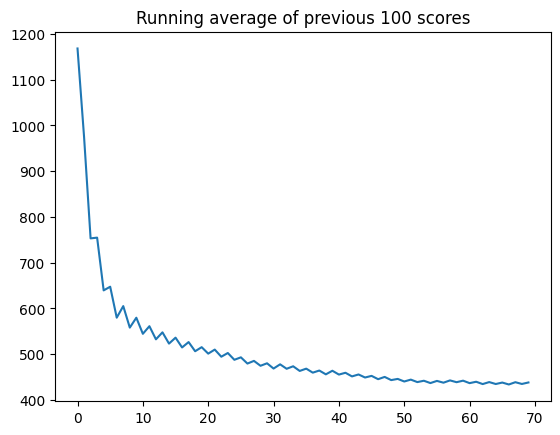

In [17]:
import numpy as np
import matplotlib.pyplot as plt

running_avg = np.zeros(len(score_history))
for i in range(len(running_avg)):
    running_avg[i] = np.mean(score_history[max(0, i-100):(i+1)])
plt.plot(running_avg)
plt.title('Running average of previous 100 scores')

Mean Power: 82682.4367821854
Median Power: 80401.53927596819
Standard Deviation of Power: 34543.62087381182
Minimum Power: 395.0528561953612
Maximum Power: 170920.95890647147


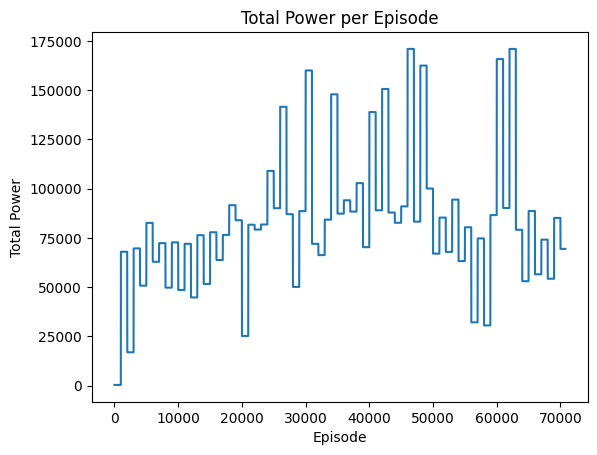

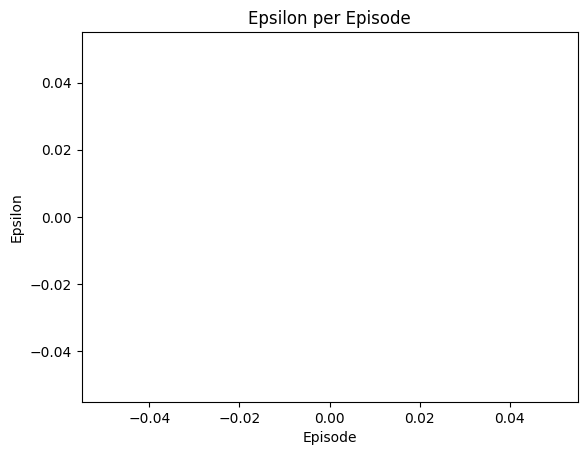

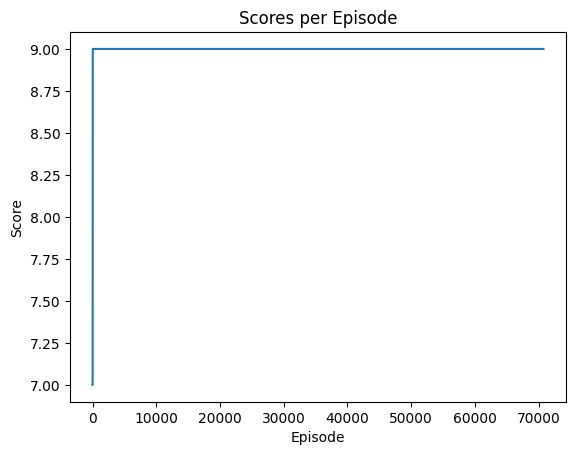

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(powers)
median_power = np.median(powers)
std_power = np.std(powers)
min_power = np.min(powers)
max_power = np.max(powers)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(powers)
plt.xlabel('Episode')
plt.ylabel('Total Power')
plt.title('Total Power per Episode')
plt.show()

plt.plot(eps_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon per Episode')
plt.show()

plt.plot(setpoints)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores per Episode')
plt.show()

In [ ]:
print(scores)